<a href="https://colab.research.google.com/github/Jeoungseungho/school_project/blob/master/neural_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('user uploaded file "{name}" with length {length} bytes'.format(name=fn,length=len(uploaded[fn])))

Saving maru.jpeg to maru.jpeg
user uploaded file "maru.jpeg" with length 203409 bytes


In [31]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('user uploaded file "{name}" with length {length} bytes'.format(name=fn,length=len(uploaded[fn])))

Saving bull.jpeg to bull.jpeg
user uploaded file "bull.jpeg" with length 76196 bytes


In [0]:
import keras

from keras.preprocessing.image import load_img, img_to_array, save_img

# 변환하려는 이미지 경로
target_image_path = './maru.jpeg'
# 스타일 이미지 경로
style_reference_image_path = './bull.jpeg'

# 생성된 사진의 차원
width, height = load_img(target_image_path).size
img_height = 400
img_width = int(width * img_height / height) # 비율에 맞춰서 줄여준다.

In [0]:
import numpy as np
from keras.applications import vgg19

def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_height, img_width))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

def deprocess_image(x):
    # VGG19.preprocess_input 함수에서 일어나는 변환을 복원하기 위해
	  # ImageNet의 평균 픽셀 값을 더하고

    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB' 으로 변환합니다.
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x


In [34]:
from keras import backend as K

# 이미 준비되어있는 이미지 이므로 constant를 이용해서 정의
target_image = K.constant(preprocess_image(target_image_path))
style_reference_image = K.constant(preprocess_image(style_reference_image_path))

# 생성된 이미지를 담을 플레이스홀더
combination_image = K.placeholder((1, img_height, img_width, 3))

# 세 개의 이미지를 하나의 배치로 합칩니다
input_tensor = K.concatenate([target_image,
                              style_reference_image,
                              combination_image], axis=0)

# 세 이미지의 배치를 입력으로 받는 VGG 네트워크를 만듭니다.
# 이 모델은 사전 훈련된 ImageNet 가중치를 로드합니다
model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet',
                    include_top=False)
print('모델 로드 완료.')

모델 로드 완료.


In [0]:
def content_loss(base, combination):
    return K.sum(K.square(combination - base))
  
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_height * img_width
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

In [0]:
def total_variation_loss(x):
    a = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, 1:, :img_width - 1, :])
    b = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, :img_height - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))


In [37]:
# 층 이름과 활성화 텐서를 매핑한 딕셔너리
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
# 콘텐츠 손실에 사용할 층
content_layer = 'block5_conv2'
# 스타일 손실에 사용할 층
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']
# 손실 항목의 가중치 평균에 사용할 가중치
total_variation_weight = 1e-4
style_weight = 1.
content_weight = 0.025

# 모든 손실 요소를 더해 하나의 스칼라 변수로 손실을 정의합니다
loss = K.variable(0.)
layer_features = outputs_dict[content_layer]
target_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss += content_weight * content_loss(target_image_features,
                                      combination_features)
for layer_name in style_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss += (style_weight / len(style_layers)) * sl
loss += total_variation_weight * total_variation_loss(combination_image)

# 손실에 대한 생성된 이미지의 그래디언트를 구합니다
grads = K.gradients(loss, combination_image)[0]

# 현재 손실과 그래디언트의 값을 추출하는 케라스 Function 객체입니다
fetch_loss_and_grads = K.function([combination_image], [loss, grads])

In [0]:
class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        x = x.reshape((1, img_height, img_width, 3))
        outs = fetch_loss_and_grads([x])
        loss_value = outs[0]
        grad_values = outs[1].flatten().astype('float64')
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()


In [39]:
from scipy.optimize import fmin_l_bfgs_b
import time

result_prefix = 'style_transfer_result'
iterations = 40



x = preprocess_image(target_image_path) # 초기 값은 타깃 이미지입니다
x = x.flatten() # scipy.optimize.fmin_l_bfgs_b 함수가 벡터만 처리할 수 있기 때문에 이미지를 펼칩니다.
for i in range(iterations):
    print('반복 횟수:', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x,
                                     fprime=evaluator.grads, maxfun=20)
    # 뉴럴 스타일 트랜스퍼의 손실을 최소화하기 위해 생성된 이미지에 대해 L-BFGS 최적화를 수행합니다
    print('현재 손실 값:', min_val)
    # 생성된 현재 이미지를 저장합니다
    img = x.copy().reshape((img_height, img_width, 3))
    img = deprocess_image(img)
    fname = result_prefix + '_at_iteration_%d.png' % i
    save_img(fname, img)
    end_time = time.time()
    print('저장 이미지: ', fname)
    print('%d 번째 반복 완료: %ds' % (i, end_time - start_time))

반복 횟수: 0
현재 손실 값: 353437730.0
저장 이미지:  style_transfer_result_at_iteration_0.png
0 번째 반복 완료: 11s
반복 횟수: 1
현재 손실 값: 145474340.0
저장 이미지:  style_transfer_result_at_iteration_1.png
1 번째 반복 완료: 8s
반복 횟수: 2
현재 손실 값: 100737550.0
저장 이미지:  style_transfer_result_at_iteration_2.png
2 번째 반복 완료: 8s
반복 횟수: 3
현재 손실 값: 72612290.0
저장 이미지:  style_transfer_result_at_iteration_3.png
3 번째 반복 완료: 8s
반복 횟수: 4
현재 손실 값: 58405140.0
저장 이미지:  style_transfer_result_at_iteration_4.png
4 번째 반복 완료: 8s
반복 횟수: 5
현재 손실 값: 51549348.0
저장 이미지:  style_transfer_result_at_iteration_5.png
5 번째 반복 완료: 8s
반복 횟수: 6
현재 손실 값: 46506684.0
저장 이미지:  style_transfer_result_at_iteration_6.png
6 번째 반복 완료: 8s
반복 횟수: 7
현재 손실 값: 42939390.0
저장 이미지:  style_transfer_result_at_iteration_7.png
7 번째 반복 완료: 8s
반복 횟수: 8
현재 손실 값: 40362308.0
저장 이미지:  style_transfer_result_at_iteration_8.png
8 번째 반복 완료: 8s
반복 횟수: 9
현재 손실 값: 38358096.0
저장 이미지:  style_transfer_result_at_iteration_9.png
9 번째 반복 완료: 8s
반복 횟수: 10
현재 손실 값: 36664304.0
저장 이미지:  style_transfer_re

In [0]:
from matplotlib import pyplot as plt
from matplotlib.image import imread

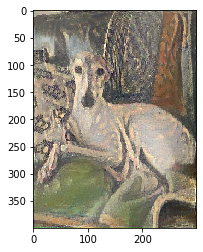

In [41]:
img = imread(fname)
plt.imshow(img)
plt.show()

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [0]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [0]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [0]:
file_name = 'stylized-image.png'
tensor_to_image(img).save(file_name)

try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(file_name)